In [179]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

#models,metrics
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, VotingClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score,roc_auc_score
from sklearn.metrics import classification_report, roc_auc_score
from sklearn.tree import DecisionTreeClassifier, export_graphviz, export_text
from sklearn.model_selection import train_test_split

#preprocessing and parameter setting
from sklearn.model_selection import GridSearchCV, cross_validate, RandomizedSearchCV, validation_curve
from sklearn.preprocessing import MinMaxScaler, LabelEncoder, StandardScaler, RobustScaler



Import the data

In [180]:
df = pd.read_csv("WA_Fn-UseC_-Telco-Customer-Churn.csv")

EDA (Exploratory Data Analysis):

In [181]:
def check_df(dataframe, head=5):
    print("Shape of the data: ")
    print(dataframe.shape)
    print("DataTypes in data:")
    print(dataframe.dtypes)
    print("Sample Head Data:")
    print(dataframe.head(head))
    print("Sample Tail Data")
    print(dataframe.tail(head))
    print("Nulls in Data:")
    print(dataframe.isnull().sum())
    print("Quantiles:")
    print(dataframe.quantile([0, 0.05, 0.50, 0.95, 0.99, 1], numeric_only=True))

check_df(df)

Shape of the data: 
(7043, 21)
DataTypes in data:
customerID           object
gender               object
SeniorCitizen         int64
Partner              object
Dependents           object
tenure                int64
PhoneService         object
MultipleLines        object
InternetService      object
OnlineSecurity       object
OnlineBackup         object
DeviceProtection     object
TechSupport          object
StreamingTV          object
StreamingMovies      object
Contract             object
PaperlessBilling     object
PaymentMethod        object
MonthlyCharges      float64
TotalCharges         object
Churn                object
dtype: object
Sample Head Data:
   customerID  gender  SeniorCitizen Partner Dependents  tenure PhoneService  \
0  7590-VHVEG  Female              0     Yes         No       1           No   
1  5575-GNVDE    Male              0      No         No      34          Yes   
2  3668-QPYBK    Male              0      No         No       2          Yes   
3  7795-CF

In [182]:
# Chaning "TotalCharges" column to numeric and any non-numeric in that column will be mapped as NaN
df["TotalCharges"] = pd.to_numeric(df["TotalCharges"], errors='coerce')

# "SeniorCitizen" to object type
df["SeniorCitizen"] = df["SeniorCitizen"].astype("O")

#Churned values to binary
df["Churn"] = df["Churn"].apply(lambda x : 1 if x == "Yes" else 0)

In [183]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 21 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        7043 non-null   object 
 1   gender            7043 non-null   object 
 2   SeniorCitizen     7043 non-null   object 
 3   Partner           7043 non-null   object 
 4   Dependents        7043 non-null   object 
 5   tenure            7043 non-null   int64  
 6   PhoneService      7043 non-null   object 
 7   MultipleLines     7043 non-null   object 
 8   InternetService   7043 non-null   object 
 9   OnlineSecurity    7043 non-null   object 
 10  OnlineBackup      7043 non-null   object 
 11  DeviceProtection  7043 non-null   object 
 12  TechSupport       7043 non-null   object 
 13  StreamingTV       7043 non-null   object 
 14  StreamingMovies   7043 non-null   object 
 15  Contract          7043 non-null   object 
 16  PaperlessBilling  7043 non-null   object 


In [184]:
def grab_col_names(dataframe, cat_th=10, car_th=20):

    # cat_cols, cat_but_car
    cat_cols = [col for col in dataframe.columns if dataframe[col].dtypes == "O"] 

    num_but_cat = [col for col in dataframe.columns if dataframe[col].nunique() < cat_th and
                   dataframe[col].dtypes != "O"]

    cat_but_car = [col for col in dataframe.columns if dataframe[col].nunique() > car_th and
                   dataframe[col].dtypes == "O"]

    cat_cols = cat_cols + num_but_cat

    cat_cols = [col for col in cat_cols if col not in cat_but_car] 

    num_cols = [col for col in dataframe.columns if dataframe[col].dtypes != "O"] 

    num_cols = [col for col in num_cols if col not in num_but_cat] 
    
    print(f"Observations: {dataframe.shape[0]}") # data frame in içerisindeki gözlem sayısına eriştik.
    print(f"Variables: {dataframe.shape[1]}") # data frame in içerisindeki değişken sayısına eriştik.
    print(f'cat_cols: {len(cat_cols)}') # kaçtane kategorik değişken olduğunu tespit ettik.
    print(f'num_cols: {len(num_cols)}') # kaç tane nümerik değişken olduğunu tespit ettik.
    print(f'cat_but_car: {len(cat_but_car)}') # kaç tane kardinal değişken olduğunu tespit ettik.
    print(f'num_but_cat: {len(num_but_cat)}') # kaç tane numerik gibi görünüp kategorik olan değişken olduğunu belirledi


    return cat_cols, num_cols, cat_but_car, num_but_cat

In [185]:
cat_cols, num_cols, cat_but_car,  num_but_cat = grab_col_names(df)

Observations: 7043
Variables: 21
cat_cols: 17
num_cols: 3
cat_but_car: 1
num_but_cat: 1


Analysis of numerical variables by Target variable:

In [186]:
def target_summary_with_num(dataframe, target, numerical_col):
    print(dataframe.groupby(target).agg({numerical_col: "mean"}), end="\n\n\n")

In [187]:
for col in num_cols:
    target_summary_with_num(df, "Churn", col)

          tenure
Churn           
0      37.569965
1      17.979133


       MonthlyCharges
Churn                
0           61.265124
1           74.441332


       TotalCharges
Churn              
0       2555.344141
1       1531.796094




Analysis of categorical variables by Target variable:

In [188]:
def target_summary_with_cat(dataframe, target, categorical_col):
    print(categorical_col)
    print(pd.DataFrame({"TARGET_MEAN": dataframe.groupby(categorical_col)[target].mean(),
                        "Count": dataframe[categorical_col].value_counts(),
                        "Ratio": 100 * dataframe[categorical_col].value_counts() / len(dataframe)}), end="\n\n\n")


In [189]:
for col in cat_cols:
    target_summary_with_cat(df, "Churn", col)

gender
        TARGET_MEAN  Count     Ratio
gender                              
Female     0.269209   3488  49.52435
Male       0.261603   3555  50.47565


SeniorCitizen
               TARGET_MEAN  Count      Ratio
SeniorCitizen                               
0                 0.236062   5901  83.785319
1                 0.416813   1142  16.214681


Partner
         TARGET_MEAN  Count     Ratio
Partner                              
No          0.329580   3641  51.69672
Yes         0.196649   3402  48.30328


Dependents
            TARGET_MEAN  Count      Ratio
Dependents                               
No             0.312791   4933  70.041176
Yes            0.154502   2110  29.958824


PhoneService
              TARGET_MEAN  Count      Ratio
PhoneService                               
No               0.249267    682   9.683374
Yes              0.267096   6361  90.316626


MultipleLines
                  TARGET_MEAN  Count      Ratio
MultipleLines                                  
No 

In [190]:
corr = df[num_cols + ["Churn"]].corr()

In [191]:
corr

,tenure,MonthlyCharges,TotalCharges,Churn
tenure,1.000000,0.247900,0.825880,-0.352229
MonthlyCharges,0.247900,1.000000,0.651065,0.193356
TotalCharges,0.825880,0.651065,1.000000,-0.199484
Churn,-0.352229,0.193356,-0.199484,1.000000


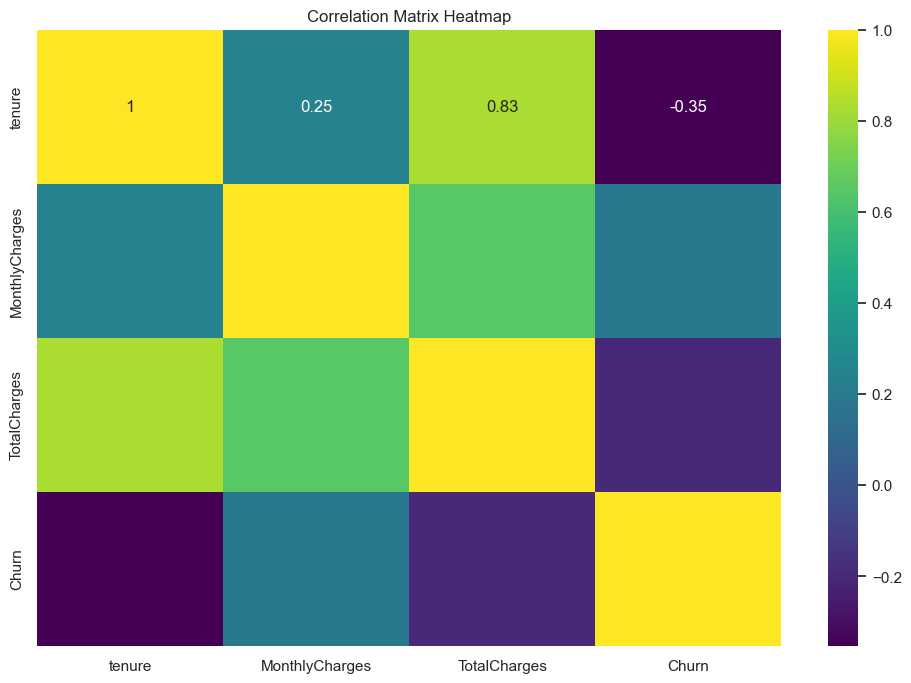

In [192]:
plt.figure(figsize=(12, 8))  # Adjust the figure size if necessary
corr_values = corr.round(2)
sns.heatmap(corr, cmap="viridis", annot=corr_values)
plt.title('Correlation Matrix Heatmap')
plt.show(block=True)

Missing Values

In [193]:
df.isnull().sum()

customerID           0
gender               0
SeniorCitizen        0
Partner              0
Dependents           0
tenure               0
PhoneService         0
MultipleLines        0
InternetService      0
OnlineSecurity       0
OnlineBackup         0
DeviceProtection     0
TechSupport          0
StreamingTV          0
StreamingMovies      0
Contract             0
PaperlessBilling     0
PaymentMethod        0
MonthlyCharges       0
TotalCharges        11
Churn                0
dtype: int64

In [194]:
df["TotalCharges"].fillna(df["TotalCharges"].median(), inplace=True)

/var/folders/75/kl_xcvmd2bldwws2ngg2mj8r0000gn/T/ipykernel_313/1479199042.py:1: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df["TotalCharges"].fillna(df["TotalCharges"].median(), inplace=True)


Outlier Analysis

In [195]:
for col in num_cols:
    quartile1 = df[col].quantile(0.05)
    quartile3 = df[col].quantile(0.95)
    iqr = quartile3-quartile1
    lower_limit = quartile1 - (1.5 * iqr)
    upper_limit = quartile3 + (1.5 * iqr)
    df.loc[(df[col] < lower_limit), col] = lower_limit
    df.loc[(df[col] > upper_limit), col] = upper_limit

/var/folders/75/kl_xcvmd2bldwws2ngg2mj8r0000gn/T/ipykernel_313/1952379010.py:7: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '-105.5' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  df.loc[(df[col] < lower_limit), col] = lower_limit


Model:

In [196]:
dff = df.copy()
cat_cols = [col for col in cat_cols if col not in ["Churn"]]
cat_cols

['gender',
 'SeniorCitizen',
 'Partner',
 'Dependents',
 'PhoneService',
 'MultipleLines',
 'InternetService',
 'OnlineSecurity',
 'OnlineBackup',
 'DeviceProtection',
 'TechSupport',
 'StreamingTV',
 'StreamingMovies',
 'Contract',
 'PaperlessBilling',
 'PaymentMethod']

Encoding the categorical variables

In [197]:
# One-Hot-Encoding

dff = pd.get_dummies(df, columns=cat_cols, drop_first=False)

In [198]:
dff.head()

,customerID,tenure,MonthlyCharges,TotalCharges,Churn,gender_Female,gender_Male,SeniorCitizen_0,SeniorCitizen_1,Partner_No,...,StreamingMovies_Yes,Contract_Month-to-month,Contract_One year,Contract_Two year,PaperlessBilling_No,PaperlessBilling_Yes,PaymentMethod_Bank transfer (automatic),PaymentMethod_Credit card (automatic),PaymentMethod_Electronic check,PaymentMethod_Mailed check
0,7590-VHVEG,1.0,29.85,29.85,0,True,False,True,False,False,...,False,True,False,False,False,True,False,False,True,False
1,5575-GNVDE,34.0,56.95,1889.50,0,False,True,True,False,True,...,False,False,True,False,True,False,False,False,False,True
2,3668-QPYBK,2.0,53.85,108.15,1,False,True,True,False,True,...,False,True,False,False,False,True,False,False,False,True
3,7795-CFOCW,45.0,42.30,1840.75,0,False,True,True,False,True,...,False,False,True,False,True,False,True,False,False,False
4,9237-HQITU,2.0,70.70,151.65,1,True,False,True,False,True,...,False,True,False,False,False,True,False,False,True,False


Standardization:

In [199]:
#Standardized the numerical values to a scale

scaler = RobustScaler()

In [200]:
dff[num_cols] = scaler.fit_transform(dff[num_cols])

In [201]:
# Creating the Dependent Variable.

y = dff["Churn"]

In [202]:
# Creating Independent Variables.

X = dff.drop(["Churn","customerID"], axis=1)

In [203]:
models = [('LR', LogisticRegression(random_state=12345)),
          ('RF', RandomForestClassifier(random_state=12345))]

In [204]:
base_models_metrics = []

In [205]:
for name, model in models:
    cv_results = cross_validate(model, X, y, cv=5, scoring=["accuracy", "f1", "roc_auc", "precision", "recall"])
    
    accuracy = round(cv_results['test_accuracy'].mean(), 4)
    auc = round(cv_results['test_roc_auc'].mean(), 4)
    recall = round(cv_results['test_recall'].mean(), 4)
    precision = round(cv_results['test_precision'].mean(), 4)
    f1 = round(cv_results['test_f1'].mean(), 4)
    
    base_models_metrics.append({
        "Model": name,
        "Accuracy": accuracy,
        "AUC": auc,
        "Recall": recall,
        "Precision": precision,
        "F1": f1
    })
    
    print(f" -- {name} --")
    print(f"Accuracy: {accuracy}")
    print(f"AUC: {auc}")
    print(f"Recall: {recall}")
    print(f"Precision: {precision}")
    print(f"F1: {f1}")


 -- LR --
Accuracy: 0.8041
AUC: 0.8452
Recall: 0.5516
Precision: 0.6554
F1: 0.5989
 -- RF --
Accuracy: 0.7889
AUC: 0.8172
Recall: 0.4842
Precision: 0.6346
F1: 0.5492


Feature Importance

In [206]:
models = [RandomForestClassifier()]

In [207]:
def plot_importance(model, features, num=len(X), save=False):
    feature_imp = pd.DataFrame({'Value': model.feature_importances_, 'Feature': features.columns})
    plt.figure(figsize=(10, 10))
    sns.set(font_scale=1)
    sns.barplot(x="Value", y="Feature", data=feature_imp.sort_values(by="Value",
                                                                      ascending=False)[0:num])
    plt.title(f'Feature Importance - {model.__class__.__name__}')
    plt.tight_layout()
    plt.show(block=True)
    if save:
        plt.savefig(f'importances_{model.__class__.__name__}.png')

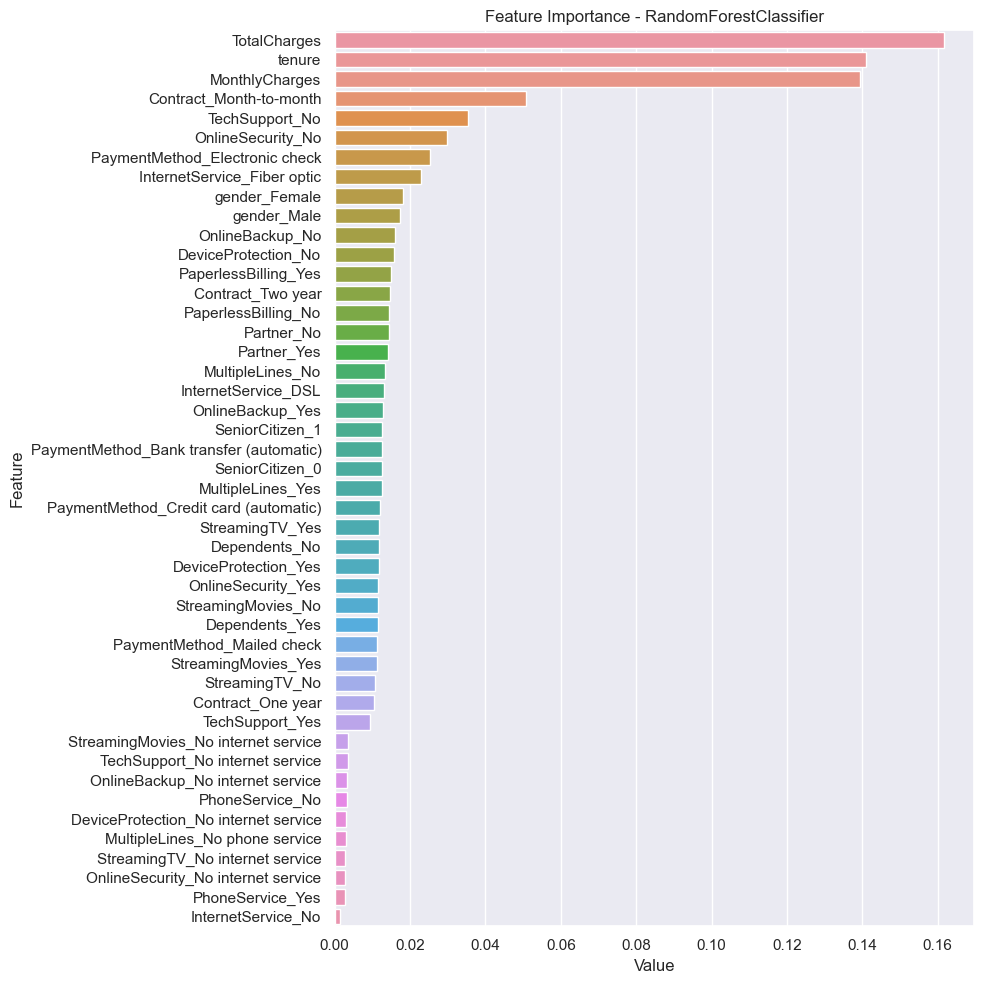

In [208]:
for model in models:
    model.fit(X, y)
    plot_importance(model, X)

Feature Extraction

In [209]:
# Create an annual categorical variable from the variable Tenure

df.loc[(df["tenure"]>=0) & (df["tenure"]<=12),"NEW_TENURE_YEAR"] = "0-1 Year"
df.loc[(df["tenure"]>12) & (df["tenure"]<=24),"NEW_TENURE_YEAR"] = "1-2 Year"
df.loc[(df["tenure"]>24) & (df["tenure"]<=36),"NEW_TENURE_YEAR"] = "2-3 Year"
df.loc[(df["tenure"]>36) & (df["tenure"]<=48),"NEW_TENURE_YEAR"] = "3-4 Year"
df.loc[(df["tenure"]>48) & (df["tenure"]<=60),"NEW_TENURE_YEAR"] = "4-5 Year"
df.loc[(df["tenure"]>60) & (df["tenure"]<=72),"NEW_TENURE_YEAR"] = "5-6 Year"

# Specify customers with a 1 or 2 year contract as Engaged

df["NEW_Engaged"] = df["Contract"].apply(lambda x: 1 if x in ["One year","Two year"] else 0)


# People who do not receive any support, backup or protection

df["NEW_noProt"] = df.apply(lambda x: 1 if (x["OnlineBackup"] != "Yes") or (x["DeviceProtection"] != "Yes") or (x["TechSupport"] != "Yes") else 0, axis=1)

# Young customers with a monthly contract

df["NEW_Young_Not_Engaged"] = df.apply(lambda x: 1 if (x["NEW_Engaged"] == 0) and (x["SeniorCitizen"] == 0) else 0, axis=1)

# Total number of services received by the person

df['NEW_TotalServices'] = (df[['PhoneService', 'InternetService', 'OnlineSecurity',
                                       'OnlineBackup', 'DeviceProtection', 'TechSupport',
                                       'StreamingTV', 'StreamingMovies']]== 'Yes').sum(axis=1)


# People who receive any streaming service

df["NEW_FLAG_ANY_STREAMING"] = df.apply(lambda x: 1 if (x["StreamingTV"] == "Yes") or (x["StreamingMovies"] == "Yes") else 0, axis=1)

# Does the person make automatic payments?

df["NEW_FLAG_AutoPayment"] = df["PaymentMethod"].apply(lambda x: 1 if x in ["Bank transfer (automatic)","Credit card (automatic)"] else 0)

# average monthly payment

df["NEW_AVG_Charges"] = df["TotalCharges"] / (df["tenure"] + 1)

# Increase in current price compared to average price

df["NEW_Increase"] = df["NEW_AVG_Charges"] / df["MonthlyCharges"]

# Fee per service

df["NEW_AVG_Service_Fee"] = df["MonthlyCharges"] / (df['NEW_TotalServices'] + 1)

In [210]:
cat_cols, num_cols, cat_but_car,  num_but_cat = grab_col_names(df)

Observations: 7043
Variables: 31
cat_cols: 24
num_cols: 6
cat_but_car: 1
num_but_cat: 7


Encoding

In [211]:
binary_cols = ['SeniorCitizen', 'gender', 'Partner', 'Dependents', 'PhoneService', 'PaperlessBilling']
labelencoder = LabelEncoder()
for col in df.columns:
    if df[col].dtypes == "O" and df[col].nunique() == 2:
        binary_cols.append(col)
        df[col] = labelencoder.fit_transform(df[col])

In [212]:
binary_cols

['SeniorCitizen',
 'gender',
 'Partner',
 'Dependents',
 'PhoneService',
 'PaperlessBilling',
 'gender',
 'SeniorCitizen',
 'Partner',
 'Dependents',
 'PhoneService',
 'PaperlessBilling']

One-Hot Encoding

In [213]:
cat_cols = [col for col in cat_cols if col not in binary_cols and col not in ["Churn", "NEW_TotalServices"]]
df = pd.get_dummies(df, columns=cat_cols, drop_first=False)

Standardization

In [214]:
scaler = RobustScaler()

In [215]:
df[num_cols] = scaler.fit_transform(df[num_cols])

In [216]:
y = df["Churn"]
X = df.drop(["Churn","customerID"], axis=1)

After Feature Engineering

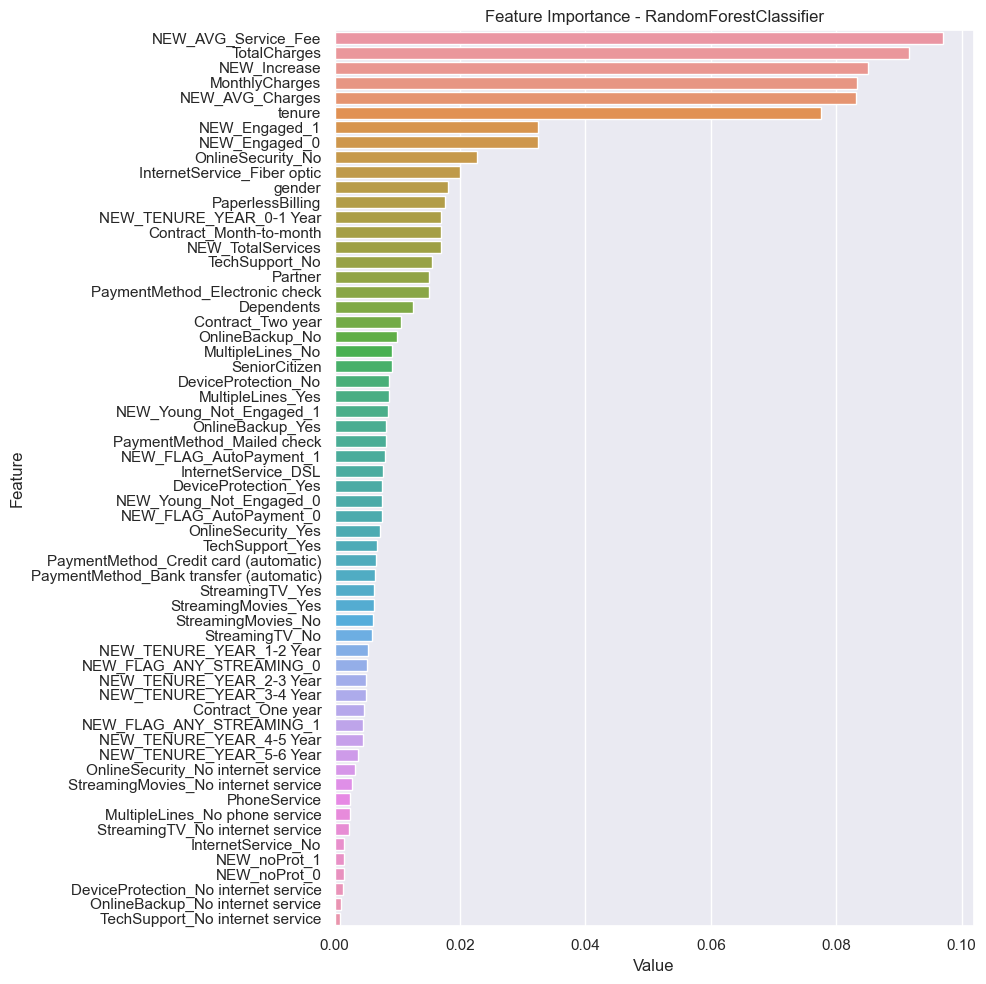

In [217]:
for model in models:
    model.fit(X, y)
    plot_importance(model, X)

Hyperparameter Optimization:

In [218]:
lr_params = {"C": [0.001, 0.01, 0.1, 1, 10, 100, 1000]}
rf_params = {"n_estimators": [100, 300, 500]}

In [219]:
classifiers = [
    ("LR", LogisticRegression(), lr_params),
    ("RF", RandomForestClassifier(), rf_params)
]

In [220]:
def hyperparameter_optimization(X, y, cv=5, scoring="accuracy"):
    print("Hyperparameter Optimizations")
    best_models = {}
    for name, classifier, params in classifiers:
        print(f"########## {name} #########")
        cv_results = cross_validate(classifier, X, y, cv=cv, scoring=scoring)
        print(f"{scoring} (Before): {round(cv_results['test_score'].mean(), 4)}")

        gs_best = GridSearchCV(classifier, params, cv=cv, n_jobs=-1, verbose=False).fit(X,y)
        final_model = classifier.set_params(**gs_best.best_params_)

        cv_results = cross_validate(final_model, X, y, cv=cv, scoring=scoring)
        print(f"{scoring} (After) : {round(cv_results['test_score'].mean(), 4)}")
        print(f"{name} best params: {gs_best.best_params_}", end="\n\n")
        best_models[name] = final_model
    return best_models

In [221]:
best_models = hyperparameter_optimization(X, y)

Hyperparameter Optimizations
########## LR #########
accuracy (Before): 0.8052
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0

/opt/miniconda3/envs/hands-on-ml/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/opt/miniconda3/envs/hands-on-ml/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_mo

accuracy (After) : 0.807
LR best params: {'C': 0.1}

########## RF #########
accuracy (Before): 0.7873
accuracy (After) : 0.7923
RF best params: {'n_estimators': 500}



In [222]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

In [263]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt

# Placeholder for accuracy scores
accuracy_scores = []

# Range of trees to test
n_trees_range = [10, 50, 100, 200, 500]

for n_trees in n_trees_range:
    rf = RandomForestClassifier(n_estimators=n_trees, random_state=42)
    rf.fit(X_train, y_train)
    y_pred = rf.predict(X_test)
    accuracy_scores.append(accuracy_score(y_test, y_pred))

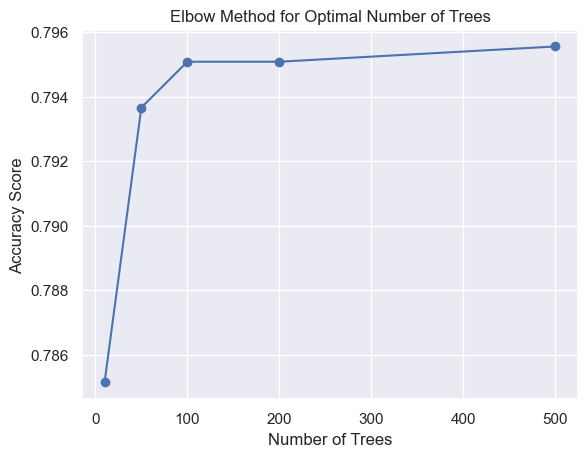

In [230]:
plt.plot(n_trees_range, accuracy_scores, marker='o')
plt.xlabel('Number of Trees')
plt.ylabel('Accuracy Score')
plt.title('Elbow Method for Optimal Number of Trees')
plt.show()


In [243]:
# Train the RandomForest model
model = RandomForestClassifier(n_estimators=200, random_state=0)
model.fit(X_train, y_train)

# Predict on the test set
y_pred = model.predict(X_test)

In [244]:
y_pred_proba = model.predict_proba(X_test)[:, 1]

# Evaluate the model
print("Accuracy:", accuracy_score(y_test, y_pred))
print("ROC AUC Score:", roc_auc_score(y_test, y_pred_proba))
print(classification_report(y_test, y_pred))

Accuracy: 0.7983909133932797
ROC AUC Score: 0.8389333768024397
              precision    recall  f1-score   support

           0       0.83      0.91      0.87      1539
           1       0.68      0.49      0.57       574

    accuracy                           0.80      2113
   macro avg       0.75      0.70      0.72      2113
weighted avg       0.79      0.80      0.79      2113



In [245]:
# Train the LogisticRegression model
model = LogisticRegression(random_state=42)
model.fit(X_train, y_train)

# Predict on the test set
y_pred_lr = model.predict(X_test)
y_pred_proba_lr = model.predict_proba(X_test)[:, 1]

# Evaluate the model
print("Accuracy:", accuracy_score(y_test, y_pred_lr))
print("ROC AUC Score:", roc_auc_score(y_test, y_pred_proba_lr))
print(classification_report(y_test, y_pred_lr))

Accuracy: 0.8017037387600567
ROC AUC Score: 0.8608252790965671
              precision    recall  f1-score   support

           0       0.83      0.91      0.87      1539
           1       0.68      0.52      0.59       574

    accuracy                           0.80      2113
   macro avg       0.76      0.71      0.73      2113
weighted avg       0.79      0.80      0.79      2113



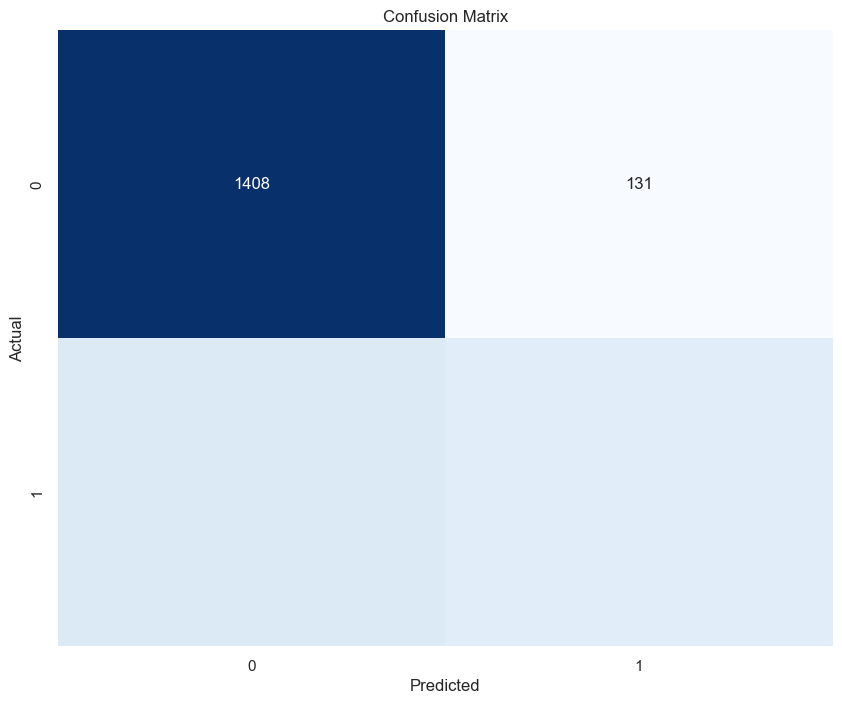

In [264]:
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y_test, y_pred)

# Step 4: Plot the confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

In [269]:
cm

array([[1408,  131],
       [ 301,  273]])